In [42]:
import glob
import os
import librosa
import librosa.display
import skimage
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 



In [43]:
metadata = pd.read_csv("UrbanSound8k/metadata/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


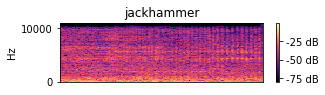

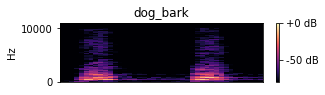

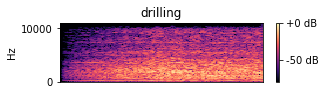

In [44]:
arr = np.array(metadata["slice_file_name"])
fold = np.array(metadata["fold"])
cla = np.array(metadata["class"])

for i in range(192, 197, 2):
    path = 'UrbanSound8k/audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [45]:
feature = []
label = []
fold = []
def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = 'UrbanSound8k/audio/fold' + str(metadata["fold"][i]) + '/' + metadata["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(metadata["classID"][i])
        fold.append(metadata["fold"][i])
    return [feature, label, fold]

In [46]:
temp = parser(metadata)
temp = np.array(temp)
data = temp.transpose()

C:\Users\Chris\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\Users\Chris\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Chris\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
<ipython-input-46-0fabb63ec721>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)


In [49]:
pd.DataFrame(data)

,0,1,2
0,"[2.3283628e-05, 0.00021359067, 0.0002844038, 0...",3,5
1,"[0.049608395, 0.049436085, 0.03691951, 0.02867...",2,5
2,"[0.030883819, 0.027941372, 0.036278624, 0.0257...",2,5
3,"[0.026432991, 0.032280095, 0.045452975, 0.0329...",2,5
4,"[0.06138195, 0.040278364, 0.02294883, 0.015539...",2,5
...,...,...,...
8727,"[0.017539999, 0.033781983, 0.02726127, 0.03459...",1,7
8728,"[0.008803302, 0.019734537, 0.016589222, 0.0081...",1,7
8729,"[0.016069045, 0.06248836, 0.062083136, 0.06402...",1,7
8730,"[0.024163222, 0.07749511, 0.06344367, 0.032645...",1,7


In [51]:
data1 = pd.DataFrame(data)
data1 = data1.rename(columns={0: "MFCC", 1: "Label", 2: "Fold"})
data1 = data1.sort_values(by=['Fold'])
data1.to_csv('UrbanSound8k_MFCC.csv')

In [58]:
xtrainpd = data1.loc[data1['Fold'] != 9]
xtestpd = data1.loc[data1['Fold'] == 9]

In [59]:
train = np.array(xtrainpd)
test = np.array(xtestpd)

In [60]:
train.shape

(7916, 3)

In [61]:
Xtrain = train[:, 0]
Ytrain = train[:, 1]
Xtest = test[:, 0]
Ytest = test[:, 1]
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(7916,) (7916,) (816,) (816,)


In [67]:
trainempty = np.empty([7916, 128])
testempty = np.empty([816, 128])

In [68]:
trainempty

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
for i in range(7916):
    trainempty[i] = (Xtrain[i])
    
for i in range(816):
    testempty[i] = (Xtest[i])

In [70]:
Y_train = to_categorical(Ytrain)
Y_test = to_categorical(Ytest)

In [71]:
Y_test.shape

(816, 10)

In [73]:
Y_train.shape

(7916, 10)

In [75]:
X_train = trainempty.reshape(7916, 16, 8, 1)
X_test = testempty.reshape(816, 16, 8, 1)
input_dim = (16, 8, 1)

In [85]:
Y_train.shape

(7916, 10)

In [86]:
Y_test.shape

(816, 10)

In [87]:
X_train.shape

(7916, 16, 8, 1)

In [88]:
X_test.shape

(816, 16, 8, 1)

In [80]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [89]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [90]:
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
159/159 [==============================] - 2s 13ms/step - loss: 1.4973 - accuracy: 0.4920 - val_loss: 2.0826 - val_accuracy: 0.4779
Epoch 2/90
159/159 [==============================] - 2s 12ms/step - loss: 1.0855 - accuracy: 0.6409 - val_loss: 2.0692 - val_accuracy: 0.5343
Epoch 3/90
159/159 [==============================] - 2s 12ms/step - loss: 0.9328 - accuracy: 0.6908 - val_loss: 2.2474 - val_accuracy: 0.4816
Epoch 4/90
159/159 [==============================] - 2s 12ms/step - loss: 0.8059 - accuracy: 0.7356 - val_loss: 2.4558 - val_accuracy: 0.5355
Epoch 5/90
159/159 [==============================] - 2s 12ms/step - loss: 0.7237 - accuracy: 0.7607 - val_loss: 2.4490 - val_accuracy: 0.5368
Epoch 6/90
159/159 [==============================] - 2s 13ms/step - loss: 0.6391 - accuracy: 0.7861 - val_loss: 2.5174 - val_accuracy: 0.6029
Epoch 7/90
159/159 [==============================] - 2s 14ms/step - loss: 0.6063 - accuracy: 0.8039 - val_loss: 2.3794 - val_accuracy: 0.6115

Epoch 58/90
159/159 [==============================] - 2s 13ms/step - loss: 0.0680 - accuracy: 0.9766 - val_loss: 4.2624 - val_accuracy: 0.5882
Epoch 59/90
159/159 [==============================] - 2s 14ms/step - loss: 0.0722 - accuracy: 0.9760 - val_loss: 4.1110 - val_accuracy: 0.6262
Epoch 60/90
159/159 [==============================] - 2s 14ms/step - loss: 0.0660 - accuracy: 0.9768 - val_loss: 4.3924 - val_accuracy: 0.6250
Epoch 61/90
159/159 [==============================] - 3s 17ms/step - loss: 0.0718 - accuracy: 0.9756 - val_loss: 4.3235 - val_accuracy: 0.6348
Epoch 62/90
159/159 [==============================] - 3s 20ms/step - loss: 0.0696 - accuracy: 0.9766 - val_loss: 4.1435 - val_accuracy: 0.6336
Epoch 63/90
159/159 [==============================] - 3s 19ms/step - loss: 0.0708 - accuracy: 0.9755 - val_loss: 4.4138 - val_accuracy: 0.6287
Epoch 64/90
159/159 [==============================] - 3s 16ms/step - loss: 0.0772 - accuracy: 0.9732 - val_loss: 4.0527 - val_accuracy:

In [108]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

26/26 [==============================] - 0s 4ms/step - loss: 4.7936 - accuracy: 0.6042
[4.793592929840088, 0.6041666865348816]


In [104]:
predictions.tolist()

[[1.1400415900197913e-07,
  4.861350433316147e-09,
  0.9514742493629456,
  2.214244254616915e-08,
  5.661679707884679e-21,
  0.04852182790637016,
  6.5863825504663964e-09,
  1.551459310669605e-20,
  1.5207279879803082e-10,
  3.782074145419756e-06],
 [3.227958536317771e-14,
  1.819804073058262e-12,
  0.040222715586423874,
  3.091171311098151e-05,
  6.06685207458213e-05,
  1.1622558915291847e-08,
  2.2592655692229777e-15,
  3.2113220527207886e-07,
  8.813913154881448e-08,
  0.9596852660179138],
 [1.7208428459980496e-07,
  5.320355267457444e-09,
  0.9202049970626831,
  1.4166118944558548e-08,
  9.39401395136484e-21,
  0.07979093492031097,
  1.007244865292023e-08,
  2.4223772596700876e-20,
  1.813351968582566e-10,
  3.870717137033353e-06],
 [2.8597926804430074e-10,
  1.4012412066222169e-05,
  0.4759867489337921,
  3.1179850338958204e-05,
  8.721509948372841e-05,
  6.872449489492283e-07,
  7.785441198393528e-07,
  2.568992272244941e-07,
  2.8094560318702453e-15,
  0.5238791108131409],
 [3.2

In [105]:
testingdata = pd.DataFrame(test).rename(columns={0: "MFCC", 1: "Label", 2: "Fold"})
testingdata['Pred'] = predictions.tolist()

In [106]:
testingdata

,MFCC,Label,Fold,Pred
0,"[26.964308, 5.80304, 0.32755533, 0.10292106, 0...",5,9,"[1.1400415900197913e-07, 4.861350433316147e-09..."
1,"[0.42540905, 0.16244802, 0.21769492, 0.5993888...",2,9,"[3.227958536317771e-14, 1.819804073058262e-12,..."
2,"[28.250977, 6.010617, 0.3350602, 0.10066836, 0...",5,9,"[1.7208428459980496e-07, 5.320355267457444e-09..."
3,"[0.0027402462, 0.02031302, 0.049158555, 0.0809...",6,9,"[2.8597926804430074e-10, 1.4012412066222169e-0..."
4,"[0.002696536, 0.015370666, 0.043416884, 0.0654...",6,9,"[3.2549538151599444e-14, 1.3700923062742731e-0..."
...,...,...,...,...
811,"[5.1203065, 4.169136, 1.9528133, 0.78296727, 0...",9,9,"[0.24767732620239258, 8.629198418930173e-06, 0..."
812,"[5.263013, 4.943022, 2.8108203, 0.8294959, 0.4...",9,9,"[7.002954953350127e-05, 4.760008960147388e-05,..."
813,"[0.64075047, 0.4836779, 0.16774657, 0.05162232...",9,9,"[0.9833404421806335, 3.2264204037346644e-06, 0..."
814,"[0.0075959847, 0.00042499954, 0.00087268214, 0...",3,9,"[1.2350908207281464e-07, 2.2037178837308602e-0..."
